# Deep Learning Optical Flow Estimation
## RAFT: Recurrent All-pairs Field Transforms for Optical Flow (ECCV 2020)

## Tutorial Objectives
1. RAFT (Recurrent All-pairs Field Transforms) 알고리즘의 이론적 배경을 이해
2. RAFT 모델의 핵심 구성 요소들을 학습 (Feature Encoder, Correlation Volume, Update Block).
3. 실제 데이터셋에서 RAFT를 구현하고 실행해봄
4. Sintel 데이터셋을 사용하여 모델을 학습하고 평가
5. Traditional optical flow 방법들과 성능을 비교분석

---

**Original Code**: https://github.com/princeton-vl/RAFT  
**Torchvision Implementation**: https://pytorch.org/vision/main/models/raft.html  
**Instructions**: Instruction figures are partially adapted from [jonassen li](https://youtu.be/r3ZtW30exoo)

**Citation**
```
@inproceedings{teed2020raft,
  title={Raft: Recurrent all-pairs field transforms for optical flow},
  author={Teed, Zachary and Deng, Jia},
  booktitle={Computer Vision--ECCV 2020: 16th European Conference, Glasgow, UK, August 23--28, 2020, Proceedings, Part II 16},
  pages={402--419},
  year={2020},
  organization={Springer}
}
```

---

## 1. Environment Setup

필요한 라이브러리를 설치하고 불러옵니다.



In [ ]:
!pip install av # 실행 후 런타임을 다시 시작하여야 반영됩니다

In [ ]:
!wget --no-check-certificate https://files.is.tue.mpg.de/sintel/MPI-Sintel-complete.zip

!unzip MPI-Sintel-complete.zip -d /content/Sintel/

In [ ]:
from pathlib import Path
import tempfile
from urllib.request import urlretrieve
from typing import Optional

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn import functional
from torch import Tensor

from torchvision.io import read_video
import torchvision.transforms.functional as F
from torchvision.transforms import ToTensor
from torchvision.datasets import KittiFlow, Sintel
from torchvision.models.optical_flow import Raft_Large_Weights
from torchvision.utils import flow_to_image, _log_api_usage_once
from torchvision.models.optical_flow.raft import ResidualBlock, FeatureEncoder, MotionEncoder, RecurrentBlock, FlowHead, UpdateBlock, MaskPredictor
from torchvision.models.optical_flow._utils import make_coords_grid, upsample_flow
from torch.nn.modules.batchnorm import BatchNorm2d
from torch.nn.modules.instancenorm import InstanceNorm2d

In [ ]:
# Click this link to watch the video
video_url = "https://download.pytorch.org/tutorial/pexelscom_pavel_danilyuk_basketball_hd.mp4"

In [ ]:
video_path = Path(tempfile.mkdtemp()) / "basketball.mp4"
_ = urlretrieve(video_url, video_path)
frames, _, _ = read_video(str(video_path), output_format="TCHW")

In [ ]:
# Pick two pairs of images for examples
img1_batch = torch.stack([frames[100], frames[150]])
img2_batch = torch.stack([frames[101], frames[151]])

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## 2. Helper Function Definitions

### 2.1 Visualization Function
이미지와 optical flow 결과를 시각화하기 위한 Helper Function들을 정의합니다.

In [ ]:
# Visualize the images
plt.rcParams["savefig.bbox"] = "tight"

def plot(imgs, **imshow_kwargs):
    """
    Visualize images in a grid format

    Args:
        imgs: List of images or list of list of images
        **imshow_kwargs: Additional arguments for imshow
    """
    if not isinstance(imgs[0], list):
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

plot(img1_batch)

## 3. Basic Concepts of RAFT

### 3.1 What is RAFT?
RAFT (Recurrent All-pairs Field Transforms)는 2020년 ECCV에서 발표된 최신 optical flow Estimation 방법입니다. 기존 방법들과 달리 iterative한 업데이트를 통해 더 정확한 optical flow를 계산합니다.

### 3.2 Key Innovations
1. **Feature Extraction**: CNN을 사용한 feature 추출
2. **Correlation Volume**: 모든 픽셀 쌍 간의 correlation 계산
3. **Iterative Updates**: GRU를 사용한 반복적 refinement

### 3.3 Architecture Overview
RAFT는 세 가지 주요 구성 요소로 구성됩니다:
- **Feature Encoder**: 입력 이미지에서 feature map 추출
- **Correlation Block**: Feature map 간의 correlation pyramid 생성
- **Update Block**: Iterative refinement를 위한 GRU 기반 업데이트

## 4. Sintel Dataset Introduction

### 4.1 Dataset Characteristics
- **MPI Sintel**: 25개의 시퀀스로 구성된 synthetic dataset
- Naturalistic effect들이 포함되어 있어 실제 환경과 유사한 조건 제공  
- Ground truth optical flow 제공으로 정량적 평가 가능

### 4.2 Data Format
- 입력: 연속된 두 프레임 (RGB 이미지)
- Ground Truth: Dense optical flow field
- 평가: End-Point Error (EPE) 사용

**Dataset website**: http://sintel.is.tue.mpg.de/

In [ ]:
# Transform the images
weights = Raft_Large_Weights.DEFAULT
transforms = weights.transforms()

def preprocess(img1_batch, img2_batch):
    """
    Preprocess image pairs for RAFT model

    Args:
        img1_batch: First image batch
        img2_batch: Second image batch

    Returns:
        Transformed image batches
    """
    img1_batch = F.resize(img1_batch, size=[520, 960], antialias=False)
    img2_batch = F.resize(img2_batch, size=[520, 960], antialias=False)
    return transforms(img1_batch, img2_batch)

In [ ]:
def sintel_transform(img1, img2, flow, mask):
    """
    Transform function for Sintel dataset

    Args:
        img1: First image
        img2: Second image
        flow: Ground truth flow
        mask: Validity mask

    Returns:
        Transformed data
    """

    # (1) flow GT를 numpy → torch 텐서로 변환, device로 이동
    flow = torch.from_numpy(flow).to(device)

    # (2) 이미지를 tensor로 변환 (PIL/numpy → torch tensor)
    trans = ToTensor()
    img1 = trans(img1)
    img2 = trans(img2)

    # (3) 이미지와 optical flow 모두 크기를 [432, 1024]로 resize (antialias는 False)
    img1 = F.resize(img1, size=[432, 1024], antialias=False)
    img2 = F.resize(img2, size=[432, 1024], antialias=False)
    flow = F.resize(flow, size=[432, 1024], antialias=False)

    # (4) 변환된 데이터 반환 (마스크는 그대로 반환)
    return img1, img2, flow, mask

In [ ]:
img1_batch, img2_batch = preprocess(img1_batch, img2_batch)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### 4.3 Dataset Example

<img src="https://drive.google.com/uc?id=1Kre-ZAH4d5ZoisJ0pW8faXpVa97qZlmD" height = 150 width=530>

In [ ]:
# Dataset loading
trainset = Sintel(root='/content/',split='train',pass_name='final',transforms=sintel_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True)

## 5. RAFT Model Architecture

**Two different types of architectures**

<img src="https://drive.google.com/uc?id=1eSCQ5GKDgpxrEZfxjXIkZjb4sy8TfHQx" height = 380 width=520>

In [ ]:
# Load the model weights
weights = Raft_Large_Weights.DEFAULT
weights = Raft_Large_Weights.verify(weights)

## 6. RAFT Model Implementation

### 6.1 RAFT Class Definition

In [ ]:
class RAFT(nn.Module):
    def __init__(self, *, feature_encoder, context_encoder, corr_block, update_block, mask_predictor=None):
        super().__init__()
        _log_api_usage_once(self)

        self.feature_encoder = feature_encoder
        self.context_encoder = context_encoder
        self.corr_block = corr_block
        self.update_block = update_block
        self.mask_predictor = mask_predictor

        # update_block이 hidden_state_size 속성을 반드시 가져야 함
        if not hasattr(self.update_block, "hidden_state_size"):
            raise ValueError("The update_block parameter should expose a 'hidden_state_size' attribute.")

    def forward(self, image1, image2, num_flow_updates: int = 12):
        """
        Forward pass of RAFT model

        Args:
            image1: First input image
            image2: Second input image
            num_flow_updates: Number of iterative updates

        Returns:
            List of predicted flows at each iteration
        """
        batch_size, _, h, w = image1.shape
        # 두 이미지 크기 일치 체크
        if (h, w) != image2.shape[-2:]:
            raise ValueError(f"input images should have the same shape, instead got ({h}, {w}) != {image2.shape[-2:]}")
        # 입력 이미지가 8로 나누어떨어지는지 체크
        if not (h % 8 == 0) and (w % 8 == 0):
            raise ValueError(f"input image H and W should be divisible by 8, instead got {h} (h) and {w} (w)")

        # feature encoder로 두 이미지를 한 번에 concat하여 피쳐 추출 (B, C, H/8, W/8)
        fmaps = self.feature_encoder(torch.cat([image1, image2], dim=0))
        # 두 이미지의 feature map 분리
        fmap1, fmap2 = torch.chunk(fmaps, chunks=2, dim=0)
        # feature map 크기 체크 (8배 downsample)
        if fmap1.shape[-2:] != (h // 8, w // 8):
            raise ValueError("The feature encoder should downsample H and W by 8")

        # correlation pyramid를 미리 계산
        self.corr_block.build_pyramid(fmap1, fmap2)

        ########### TODO 논문에서 context encoder 를 어느 이미지에 적용했는지 확인하고, 구현하세요 (1 line) #########
        # 보통 context encoder는 첫 번째 이미지(image1)에 적용 (논문 Fig. 2 참고)
        context_out =

        # context encoder 결과 크기 체크
        if context_out.shape[-2:] != (h // 8, w // 8):
            raise ValueError("The context encoder should downsample H and W by 8")

        # hidden_state와 context 분리 (출력 채널 분할)
        hidden_state_size = self.update_block.hidden_state_size
        out_channels_context = context_out.shape[1] - hidden_state_size
        if out_channels_context <= 0:
            raise ValueError(
                f"The context encoder outputs {context_out.shape[1]} channels, but it should have at strictly more than hidden_state={hidden_state_size} channels"
            )
        hidden_state, context = torch.split(context_out, [hidden_state_size, out_channels_context], dim=1)
        # hidden_state는 tanh, context는 relu 활성화
        hidden_state = torch.tanh(hidden_state)
        context = functional.relu(context)

        # 8배 downsample grid 생성 (coords0: base, coords1: flow update용)
        coords0 = make_coords_grid(batch_size, h // 8, w // 8).to(fmap1.device)
        coords1 = make_coords_grid(batch_size, h // 8, w // 8).to(fmap1.device)

        flow_predictions = []
        for _ in range(num_flow_updates):
            coords1 = coords1.detach()
            # corr block에서 coords1 위치의 correlation feature 추출
            corr_features = self.corr_block.index_pyramid(centroids_coords=coords1)

            ############## TODO 위 코드의 내용을 이해하여 flow 텐서를 만드세요 (1 line) ##############


            # update_block을 통해 hidden_state 및 flow 변화량(delta_flow) 업데이트
            hidden_state, delta_flow = self.update_block(hidden_state, context, corr_features, flow)

            ############### TODO coords1를 업데이트하세요 (1 line) ################


            # mask predictor가 있으면 mask로 flow upsampling
            up_mask = None if self.mask_predictor is None else self.mask_predictor(hidden_state)
            # upsampled_flow = upsample_flow(flow=(coords1 - coords0), up_mask=up_mask)
            upsampled_flow = upsample_flow(flow=(coords1 - coords0), up_mask=up_mask)
            flow_predictions.append(upsampled_flow)

        return flow_predictions

### 6.2 Feature Extraction

RAFT에서는 CNN을 사용하여 입력 이미지에서 feature map을 추출합니다. Feature Encoder와 Context Encoder 두 종류의 인코더를 사용합니다.

<img src="https://drive.google.com/uc?id=1OcZKNogAq016KBNHKhbTdynL3eThqJzn" height = 300 width=700>

In [ ]:
feature_encoder =FeatureEncoder(
    block=ResidualBlock, layers=(64, 64, 96, 128, 256), norm_layer=InstanceNorm2d
)
context_encoder = FeatureEncoder(
    block=ResidualBlock, layers=(64, 64, 96, 128, 256), norm_layer=BatchNorm2d
)

### 6.3 Correlation Pyramid

RAFT의 핵심 구성 요소 중 하나인 Correlation Pyramid를 구성합니다. 두 feature map 간의 correlation volume을 계산하고 다양한 해상도에서 pooling을 수행합니다.

<img src="https://drive.google.com/uc?id=1WZGjgZQCfS07XESRuUXjQQTB6bT_mg7x" height = 300 width=700>
<img src="https://drive.google.com/uc?id=1Vk3vvhuE3jJ4oUAWPzOyjN6nfrPJ-RNT" height = 300 width=700>

### 6.4 Correlation Lookup

Correlation pyramid에서 특정 픽셀 위치의 correlation features를 추출하는 과정입니다. 중심점 주변의 이웃 픽셀들을 infinity norm 기준으로 샘플링합니다.

<img src="https://drive.google.com/uc?id=1fVZezNE2_SW6aYZ8NYqTa4AGViu3Pt_j" height = 200 width=500>
<br>
<img src="https://drive.google.com/uc?id=1wodOcnCjROyv0av8fIr-ZXF3BmiOajTP" height = 280 width=480>
<br>
<img src="https://drive.google.com/uc?id=1oTlCGrpeASqjsDqPRrwdSw6_Vs1HgqJ3" height = 35 width=280>
<br>
<img src="https://drive.google.com/uc?id=1PUwAHV-VzcnYgs2Blr8nTNL1oZSYhwNj" height = 50 width=380>

In [ ]:
def grid_sample(img: Tensor, absolute_grid: Tensor, mode: str = "bilinear", align_corners: Optional[bool] = None):
    """torch의 grid_sample과 동일하지만, normalized grid가 아니라 절대 pixel 좌표로 입력받는 함수"""
    h, w = img.shape[-2:]

    # grid의 x/y를 분리해서, -1~1 사이의 normalized 좌표로 변환
    xgrid, ygrid = absolute_grid.split([1, 1], dim=-1)
    xgrid = 2 * xgrid / (w - 1) - 1
    # stereo 등 h=1일 때 예외처리 위해 조건 추가
    if h > 1:
        ygrid = 2 * ygrid / (h - 1) - 1
    normalized_grid = torch.cat([xgrid, ygrid], dim=-1)

    # 변환된 grid로 torch의 grid_sample 호출
    return functional.grid_sample(img, normalized_grid, mode=mode, align_corners=align_corners)

class CorrBlock(nn.Module):
    """Correlation block: feature map 2개에서 correlation pyramid(multi-level correlation pyramid) 구성 및 인덱싱.

    1. feature_encoder 출력 2개를 입력 받아 correlation volume을 계산
    2. 여러 해상도로 avg_pool2d 다운샘플링하여 pyramid 생성
    3. 지정한 중심 좌표로부터 반경 내 (2r+1)x(2r+1) 이웃값을 추출
    """

    def __init__(self, *, num_levels: int = 4, radius: int = 4):
        super().__init__()
        self.num_levels = num_levels
        self.radius = radius

        self.corr_pyramid: List[Tensor] = [torch.tensor(0)]  # torchscript용 더미값
        self.out_channels = num_levels * (2 * radius + 1) ** 2

    def build_pyramid(self, fmap1, fmap2):
        """두 feature map으로부터 correlation pyramid 생성

        1. 각 위치 쌍 (fmap1, fmap2)에 대해 내적(dot product)으로 correlation volume 계산
        2. 마지막 2차원(H, W)을 avg_pool2d로 다운샘플하여 여러 해상도 pyramid 만듦
        """
        # pyramid 마지막 해상도에서 최소 2 픽셀 보장 (다운샘플링용)
        min_fmap_size = 2 * (2 ** (self.num_levels - 1))
        if any(fmap_size < min_fmap_size for fmap_size in fmap1.shape[-2:]):
            raise ValueError(
                "Feature maps are too small to be down-sampled by the correlation pyramid. "
                f"H and W of feature maps should be at least {min_fmap_size}; got: {fmap1.shape[-2:]}. "
                "Remember that input images to the model are downsampled by 8, so that means their "
                f"dimensions should be at least 8 * {min_fmap_size} = {8 * min_fmap_size}."
            )

        # (1) correlation volume 계산 (correlation volume shape: [B, H, W, 1, H, W])
        corr_volume = self._compute_corr_volume(fmap1, fmap2)

        # (2) shape 변환: (B, H, W, 1, H, W) → (B*H*W, 1, H, W)
        batch_size, h, w, num_channels, _, _ = corr_volume.shape
        corr_volume = corr_volume.reshape(batch_size * h * w, num_channels, h, w)
        self.corr_pyramid = [corr_volume]  # 첫 레벨 저장

        ####### TODO correlation pyramid 생성(다운샘플) 및 self.corr_pyramid 완성 (num_levels만큼) (3 lines) #######
        # 각 레벨마다 avg_pool2d로 해상도를 1/2로 줄여 새로운 corr_volume 추가
        # 힌트: F.avg_pool2d 사용


    def index_pyramid(self, centroids_coords):
        """correlation pyramid에서 지정한 중심좌표로부터 (2r+1)x(2r+1) 이웃 correlation feature 추출"""
        neighborhood_side_len = 2 * self.radius + 1
        # (i, j) 방향으로 반경 내 grid 오프셋 생성 (meshgrid)
        di = torch.linspace(-self.radius, self.radius, neighborhood_side_len)
        dj = torch.linspace(-self.radius, self.radius, neighborhood_side_len)
        delta = torch.stack(torch.meshgrid(di, dj, indexing="ij"), dim=-1).to(centroids_coords.device)
        delta = delta.view(1, neighborhood_side_len, neighborhood_side_len, 2)

        batch_size, _, h, w = centroids_coords.shape  # _ = 2
        # 중심 좌표를 (B*H*W, 1, 1, 2) shape로 변환
        centroids_coords = centroids_coords.permute(0, 2, 3, 1).reshape(batch_size * h * w, 1, 1, 2)

        indexed_pyramid = []
        # pyramid 각 레벨에서 지정 좌표 주변 (delta 반경) neighborhood를 샘플링
        for corr_volume in self.corr_pyramid:

            ####### TODO 중심점(centroids_coords)에서 (2r+1)x(2r+1) 이웃 sampling_coords 계산 (1 line) #######
            # 샘플링할 좌표: 중심점 좌표 + 반경 내 delta 좌표 오프셋

            # grid_sample로 neighborhood 값 추출, (B, H, W, side_len*side_len)
            indexed_corr_volume = functional.grid_sample(
                corr_volume, sampling_coords, align_corners=True, mode="bilinear"
            ).view(batch_size, h, w, -1)
            indexed_pyramid.append(indexed_corr_volume)
            # 다음 레벨(더 작은 해상도)에서는 좌표를 1/2로 축소
            centroids_coords = centroids_coords / 2

        # 모든 레벨을 concat → [B, out_channels, H, W]
        corr_features = torch.cat(indexed_pyramid, dim=-1).permute(0, 3, 1, 2).contiguous()
        return corr_features

    def _compute_corr_volume(self, fmap1, fmap2):
        batch_size, num_channels, h, w = fmap1.shape
        # (B, C, H, W) → (B, C, H*W)로 펼침
        fmap1 = fmap1.view(batch_size, num_channels, h * w)
        fmap2 = fmap2.view(batch_size, num_channels, h * w)

        ################### TODO Correlation Volume(상관 볼륨) 생성(3 line) ##################
        # 각 위치의 feature 벡터 내적(dot)으로 (B, H*W, H*W) correlation 행렬 생성
        corr =    # (B, H*W, H*W)
        corr =         # (B, H, W, 1, H, W)
        # 채널 수 sqrt로 정규화
        return

corr_block = CorrBlock(num_levels=4, radius=4)

In [ ]:
# CorrBlock에서 계산된 correlation feature의 출력 채널 수를 입력으로 사용하여 MotionEncoder 생성
motion_encoder = MotionEncoder(
    in_channels_corr=corr_block.out_channels,
    corr_layers=(256, 192),
    flow_layers=(128, 64),
    out_channels=128,
)

# context encoder의 출력 채널 수(256)에서 hidden state 크기(128)를 빼서 context 채널 수 계산
out_channels_context = 256 - 128

# MotionEncoder의 출력 feature와 context feature를 concat한 값을 입력으로 RecurrentBlock 생성
recurrent_block = RecurrentBlock(
    input_size=motion_encoder.out_channels + out_channels_context,
    hidden_size=128,
    kernel_size=((1,5),(5,1)),
    padding=((0,2), (2,0)),
)

### 6.5 Iterative Update

RAFT의 핵심인 iterative update 과정입니다. GRU 기반의 Update Block을 사용하여 optical flow를 점진적으로 개선합니다.

<img src="https://drive.google.com/uc?id=1Wv5UF8j0Wdzr_LTd8EYfuDqJSk5AoDRn" height = 30 width=310>
<br>
<img src="https://drive.google.com/uc?id=1P-XlS5_fKWrw2i-wp6pbBMUOInqOFavI" height = 200 width=500>
<br>
<img src="https://drive.google.com/uc?id=1spB6od2gHqOld7st76nW9vPV_K4FkxHN" height = 30 width=180>

In [ ]:
# MotionEncoder의 출력 feature를 받아 optical flow (u, v) 벡터를 예측하는 head 정의
flow_head = FlowHead(in_channels=128, hidden_size=256)

# UpdateBlock은 optical flow refinement 과정의 핵심 블록 (motion, context, recurrent, flow 예측 기능 모두 결합)
update_block = UpdateBlock(motion_encoder=motion_encoder, recurrent_block=recurrent_block, flow_head=flow_head)

### 6.6 Convex Upsampling

저해상도에서 계산된 optical flow를 원본 해상도로 upsampling하는 과정입니다. Convex combination을 사용하여 부드러운 결과를 얻습니다.

<img src="https://drive.google.com/uc?id=1hjx9Nf_Xz8aRD7RQ1kta29mj9lfPxkcr" height = 350 width=450>

In [ ]:
# Flow upsampling을 위한 mask(가중치)를 예측하는 MaskPredictor 생성
mask_predictor = MaskPredictor(
    in_channels=128,
    hidden_size=256,
    multiplier=0.25,
)

In [ ]:
# RAFT 모델 인스턴스 생성
model = RAFT(
    feature_encoder=feature_encoder,      # 입력 이미지의 특징 추출용 feature encoder
    context_encoder=context_encoder,      # context 정보 추출용 encoder (recurrent block의 입력용)
    corr_block=corr_block,                # correlation pyramid 계산용 블록
    update_block=update_block,            # optical flow refinement용 update block
    mask_predictor=mask_predictor         # flow upsampling weight 예측용 mask predictor
)

if weights is not None:
    model.load_state_dict(weights.get_state_dict(progress=False))

model = model.to(device)

## 7. Model Training Configuration

### 7.1 Training Parameters

모델 학습을 위한 매개변수 설정 및 최적화 함수를 정의합니다.

In [ ]:
# optimization arguments

lr=1e-9
optimizer = optim.Adam(model.parameters(),lr=lr, weight_decay=5e-4)
logging = 10
torch.manual_seed(3)

### 7.2 Objective Function

RAFT의 손실 함수는 각 반복 단계에서의 예측 결과와 ground truth 간의 차이를 계산합니다. 가중치는 반복이 진행될수록 커집니다.

<img src="https://drive.google.com/uc?id=1tWxR90kG0b2_YHx_s8kl_4ViJzNYe1Gj" height = 60 width=220>

In [ ]:
def sequence_loss(flow_list, flow_gt, gamma=0.7, weights=0.1):
    """
    Computes the sequence loss for RAFT-style multi-step flow prediction.

    Args:
        flow_list (list of Tensor): List of predicted flows at each iteration.
        flow_gt (Tensor): Ground truth optical flow.
        gamma (float): Discount factor for weighting each prediction (default: 0.7).
        weights (float): Overall scaling factor for the loss (default: 0.1).

    Returns:
        torch.Tensor: Weighted total flow loss (scalar).
    """
    n_preds = len(flow_list)   # 예측 단계 수
    flow_loss = 0.0
    for i in range(n_preds):
        #### TODO Objective function(논문 수식) 확인 후 구현 (3 lines) ####
        # i_weight: 마지막 예측에 더 큰 가중치 (gamma^step)
        i_weight =
        # i_loss: 예측 flow와 GT의 L1 절대 오차(평균)
        i_loss =
        # flow_loss: 각 단계별 weighted sum 누적


    # 전체 loss에 scale 팩터 곱해서 반환
    return weights * flow_loss

In [ ]:
# 이 셀을 실행한 이후 코드를 처음부터 다시 돌릴 일이 있을 시 런타임 재시작을 권장드립니다
model = model.train()

for batch_idx, (img1, img2, flow) in enumerate(trainloader):
    img1,img2, flow = img1.to(device),img2.to(device), flow.to(device)
    optimizer.zero_grad()
    output = model(img1,img2, num_flow_updates=12) # (B, 2, H, W). each entry corresponds to the horizontal and vertical displacement.
    loss = sequence_loss(output, flow)
    if batch_idx % logging == 0:
        print(f"iters: {batch_idx}/{len(trainloader)}, loss: {loss.item():.4f}")
    loss.backward()
    optimizer.step() # backpropagation

# 몇 분 정도 소요될 수 있습니다


## 8. Model Evaluation

### 8.1 Inference Mode

학습된 모델을 사용하여 optical flow를 예측하고 결과를 시각화합니다.

In [ ]:
model = model.eval()

In [ ]:
list_of_flows = model(img1_batch.to(device), img2_batch.to(device))
print(f"type = {type(list_of_flows)}")
print(f"length = {len(list_of_flows)} = number of iterations of the model")

predicted_flows = list_of_flows[-1]
print(f"dtype = {predicted_flows.dtype}")
print(f"shape = {predicted_flows.shape} = (N, 2, H, W)")
print(f"min = {predicted_flows.min()}, max = {predicted_flows.max()}")

### 8.2 Visualization

예측된 optical flow를 시각화하여 결과를 확인합니다. Flow vector는 색상으로 인코딩되어 표시됩니다.

<img src="https://drive.google.com/uc?id=1hgtIEEqXL26AUUcJ9PcZqItQb7EGsE_X" height = 200 width=600>

In [ ]:
# visualize the results

# 예측된 flow 결과를 시각화 이미지로 변환 (flow를 RGB 이미지로 매핑)
flow_imgs = flow_to_image(predicted_flows)  # flow를 RGB 이미지로 매핑 (supports batches of flows)

img1_batch = [(img1 + 1) / 2 for img1 in img1_batch]

grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_imgs)]

plot(grid)

예상 결과:
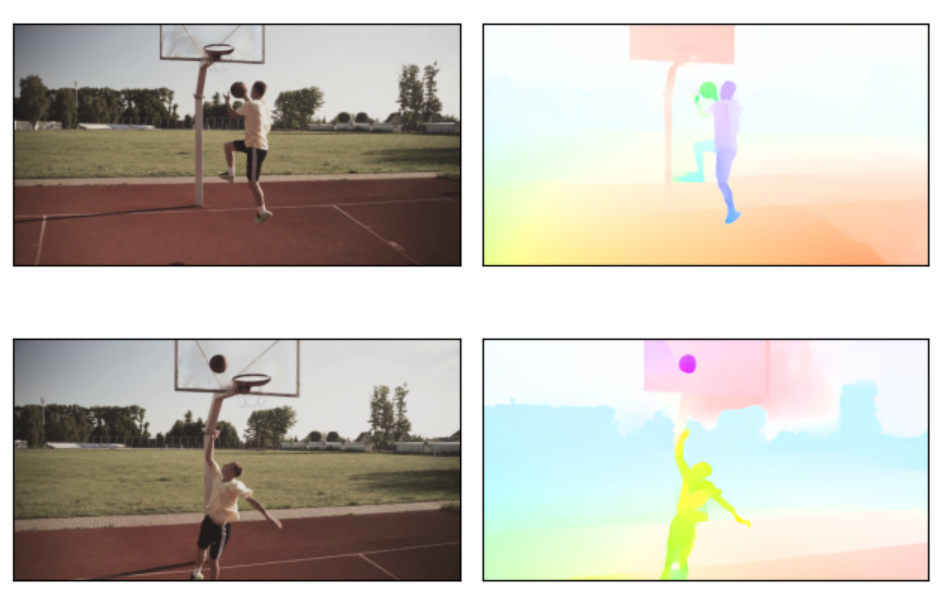